<a href="https://colab.research.google.com/github/abhisuj/MSDS-451-Programming-Assignment1/blob/main/451_pa1_bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2><font color='#306998'><center>451 Financial Engineering: Programming Assignment 1</center></font></h2>
<h3><center>Abhijit Joshi, Oct 5, 2025</center></h3>
<h3><center>Original code - Thomas W. Miller, June 18, 2025</center></h3>
---

## Overview
We use machine learning classifiers, including tree-based ensemble boosting methods, to predict the direction of Bitcoin (BTC-USD) spot prices (up or down) using a number of lagged price features. In particular, we look at daily closing spot prices for Bitcoin (ticker BTC-USD) with lags of one to seven days, as well as features based on opening, closing, high, and low price points, and daily trading volume.

A model for predicting the direction of daily returns sets the stage for testing the predictive utility of additional features. The domain of potential features or leading indicators is wide, including those associated with other price series, economic indicators, international events, securities filings, analyst and news reports, and media measures.

In this notebook, we implemented and evaluated a trading strategy based on the predicted direction of Bitcoin spot prices. The strategy involves buying when the model predicts an upward movement and selling a portion of the holdings when it predicts a downward movement. We compared the performance of this strategy to a simple buy and hold approach.

### Import Libraries
We draw on Python packages for data manipulation and modeling. Most important are Polars, a high-performance alternative to Pandas for data manipulation, and Scikit-Learn for machine learning study design and modeling algorithms.

In [1]:
import os
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import Python Packages for data manipulation, data pipelines, and databases
import numpy as np
import pyarrow # foundation for polars
import polars as pl # DataFrame work superior to Pandas

# Plotting
import matplotlib.pyplot as plt
# Display static plots directly in the notebook output
%matplotlib inline
# create stylized visualizations, including heat maps
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (RandomizedSearchCV,
                                    TimeSeriesSplit)
from sklearn.model_selection import cross_validate

# utilized in all possible subsets classification work
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# needed for randomized search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# metrics in xgboost tuning and final model evaluation
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             roc_curve,
                             roc_auc_score,
                             RocCurveDisplay,
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                             precision_score,
                             recall_score,
                             f1_score
                            )

# XGBoost Package... more complete than SciKit-Learn boosting methods
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance

import yfinance as yf

import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [5]:
# download bitcoin futures data from yfinance
# Bitcoin started trading in September 2014. We will download data until the latest trading day
symbol = 'BTC-USD'
start_date = '2014-09-01'
end_date = '2025-10-12'

ticker = yf.Ticker(symbol)
historical_data = ticker.history(start = start_date, end = end_date)
print(historical_data)

print("type of historical_data", type(historical_data))

historical_data.to_csv("btc_historical_data.csv")

                                    Open           High            Low  \
Date                                                                     
2014-09-17 00:00:00+00:00     465.864014     468.174011     452.421997   
2014-09-18 00:00:00+00:00     456.859985     456.859985     413.104004   
2014-09-19 00:00:00+00:00     424.102997     427.834991     384.532013   
2014-09-20 00:00:00+00:00     394.673004     423.295990     389.882996   
2014-09-21 00:00:00+00:00     408.084991     412.425995     393.181000   
...                                  ...            ...            ...   
2025-10-07 00:00:00+00:00  124752.140625  125184.023438  120681.968750   
2025-10-08 00:00:00+00:00  121448.351562  124167.093750  121119.179688   
2025-10-09 00:00:00+00:00  123337.070312  123739.343750  119812.031250   
2025-10-10 00:00:00+00:00  121704.742188  122509.664062  104582.414062   
2025-10-11 00:00:00+00:00  113236.429688  113429.726562  109760.562500   

                                   Cl

### Polars DataFrame Development
The following code cell demonstrates Polars use with the time series DataFrame for our selected market/ticker, BTC.

In [6]:
btc = pl.read_csv("btc_historical_data.csv", try_parse_dates=True)

# check the original schema
print(btc.schema)

# drop useless columns Dividends and StockSplits
btc = btc.drop(['Dividends', 'Stock Splits'])

# create lag price features
btc = btc.with_columns((pl.col('Close')).shift().alias('CloseLag1'))
btc = btc.with_columns((pl.col('CloseLag1')).shift().alias('CloseLag2'))
btc = btc.with_columns((pl.col('CloseLag2')).shift().alias('CloseLag3'))

# create high-minus-low (HML) for day and its lags
btc = btc.with_columns((pl.col('High') - pl.col('Low')).alias('HML'))
btc = btc.with_columns((pl.col('HML')).shift().alias('HMLLag1'))
btc = btc.with_columns((pl.col('HMLLag1')).shift().alias('HMLLag2'))
btc = btc.with_columns((pl.col('HMLLag2')).shift().alias('HMLLag3'))

# create a net change for the day as the open minus closing price OMC
# also create the corresponding lag metrics
btc = btc.with_columns((pl.col('Open') - pl.col('Close')).alias('OMC'))
btc = btc.with_columns((pl.col('OMC')).shift().alias('OMCLag1'))
btc = btc.with_columns((pl.col('OMCLag1')).shift().alias('OMCLag2'))
btc = btc.with_columns((pl.col('OMCLag2')).shift().alias('OMCLag3'))

# create volume lag metrics
btc = btc.with_columns((pl.col('Volume')).shift().alias('VolumeLag1'))
btc = btc.with_columns((pl.col('VolumeLag1')).shift().alias('VolumeLag2'))
btc = btc.with_columns((pl.col('VolumeLag2')).shift().alias('VolumeLag3'))

# compute 10-day exponential moving averages of closing prices
# compute around CloseLag1 to avoid any "leakage" in explanatory variable set
# note also the 10-day buffer between train and test in time-series cross-validation
btc = btc.with_columns((pl.col('CloseLag1').ewm_mean(half_life=1,ignore_nulls=True)).alias('CloseEMA2'))
btc = btc.with_columns((pl.col('CloseLag1').ewm_mean(half_life=2,ignore_nulls=True)).alias('CloseEMA4'))
btc = btc.with_columns((pl.col('CloseLag1').ewm_mean(half_life=4,ignore_nulls=True)).alias('CloseEMA8'))

# log daily returns
btc = btc.with_columns(np.log(pl.col('Close')/pl.col('CloseLag1')).alias('LogReturn'))

"""
# Calculate RSI (Relative Strength Index) for CloseLag1, CloseLag2, and CloseLag3
for lag in range(1, 4):
    close_lag_col = f'CloseLag{lag}'
    delta_col = f'delta_{lag}'
    gain_col = f'gain_{lag}'
    loss_col = f'loss_{lag}'
    rs_col = f'rs_{lag}'
    rsi_col = f"RSI_CloseLag{lag}"

    btc = btc.with_columns([
        pl.col(close_lag_col).diff(1).alias(delta_col)
    ]).with_columns([
        pl.when(pl.col(delta_col) > 0).then(pl.col(delta_col)).otherwise(0).alias(gain_col),
        pl.when(pl.col(delta_col) < 0).then(-pl.col(delta_col)).otherwise(0).alias(loss_col)
    ]).with_columns([
         pl.col(gain_col).ewm_mean(span=14, adjust=False).alias(gain_col),
         pl.col(loss_col).ewm_mean(span=14, adjust=False).alias(loss_col)
    ]).with_columns([
        (pl.col(gain_col) / pl.col(loss_col)).alias(rs_col)
    ]).with_columns([
        (100 - (100 / (1 + pl.col(rs_col)))).alias(rsi_col)
    ])
    # Drop the intermediate columns if desired
    btc = btc.drop([delta_col, gain_col, loss_col, rs_col])
"""

# set volume features to Float64 for subsequent use in Numpy arrays
btc = btc.with_columns(
    pl.col('Volume').cast(pl.Float64).round(0),
    pl.col('VolumeLag1').cast(pl.Float64).round(0),
    pl.col('VolumeLag2').cast(pl.Float64).round(0),
    pl.col('VolumeLag3').cast(pl.Float64).round(0),
    )

# round other features to three decimal places for reporting and subsequent analytics
btc = btc.with_columns(
    pl.col('Open').round(3),
    pl.col('High').round(3),
    pl.col('Low').round(3),
    pl.col('Close').round(3),
    pl.col('CloseLag1').round(3),
    pl.col('CloseLag2').round(3),
    pl.col('CloseLag3').round(3),
    pl.col('HML').round(3),
    pl.col('HMLLag1').round(3),
    pl.col('HMLLag2').round(3),
    pl.col('HMLLag3').round(3),
    pl.col('OMC').round(3),
    pl.col('OMCLag1').round(3),
    pl.col('OMCLag2').round(3),
    pl.col('OMCLag3').round(3),
    pl.col('CloseEMA2').round(3),
    pl.col('CloseEMA4').round(3),
    pl.col('CloseEMA8').round(3),
  #  pl.col('RSI_CloseLag1').round(3),
  #  pl.col('RSI_CloseLag2').round(3),
  #  pl.col('RSI_CloseLag3').round(3)
    )

# define binary target/response 1 = market price up since previous day, 0 = even or down
btc = btc.with_columns(pl.when(pl.col('LogReturn')>0.0).then(pl.lit(1)).otherwise(pl.lit(0)).alias('Target'))

print(btc.schema)

# save to external comma-delimited text file for checking calculations in Excel
btc.write_csv("btc-with-computed-features.csv")

Schema({'Date': Datetime(time_unit='us', time_zone='UTC'), 'Open': Float64, 'High': Float64, 'Low': Float64, 'Close': Float64, 'Volume': Int64, 'Dividends': Float64, 'Stock Splits': Float64})
Schema({'Date': Datetime(time_unit='us', time_zone='UTC'), 'Open': Float64, 'High': Float64, 'Low': Float64, 'Close': Float64, 'Volume': Float64, 'CloseLag1': Float64, 'CloseLag2': Float64, 'CloseLag3': Float64, 'HML': Float64, 'HMLLag1': Float64, 'HMLLag2': Float64, 'HMLLag3': Float64, 'OMC': Float64, 'OMCLag1': Float64, 'OMCLag2': Float64, 'OMCLag3': Float64, 'VolumeLag1': Float64, 'VolumeLag2': Float64, 'VolumeLag3': Float64, 'CloseEMA2': Float64, 'CloseEMA4': Float64, 'CloseEMA8': Float64, 'LogReturn': Float64, 'Target': Int32})


### Descriptive Statistics for Price Features

In [7]:
# Drop the rows with null values such as the initial lag rows
btc = btc.drop_nulls()

if 'RSI_CloseLag3' in btc.columns:
  btc = btc.filter(~pl.col("RSI_CloseLag3").is_nan())

# Descriptive statistics
btcStatistics = btc.drop('Date').describe()

print(btcStatistics.columns)

btcStatisticsToPrint = btcStatistics.transpose(include_header=True).drop(['column_1', 'column_5', 'column_7'])

print(btcStatisticsToPrint.schema)

with pl.Config(
    tbl_rows = 60,
    tbl_width_chars = 200,
    tbl_cols = -1,
    float_precision = 3,
    tbl_hide_dataframe_shape = True,
    tbl_hide_column_data_types = True):
    print(btcStatisticsToPrint)

['statistic', 'Open', 'High', 'Low', 'Close', 'Volume', 'CloseLag1', 'CloseLag2', 'CloseLag3', 'HML', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMC', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8', 'LogReturn', 'Target']
Schema({'column': String, 'column_0': String, 'column_2': String, 'column_3': String, 'column_4': String, 'column_6': String, 'column_8': String})
┌────────────┬──────────┬───────────────────────┬─────────────────────┬──────────────────────┬───────────────────────┬─────────────────────┐
│ column     ┆ column_0 ┆ column_2              ┆ column_3            ┆ column_4             ┆ column_6              ┆ column_8            │
╞════════════╪══════════╪═══════════════════════╪═════════════════════╪══════════════════════╪═══════════════════════╪═════════════════════╡
│ statistic  ┆ count    ┆ mean                  ┆ std                 ┆ min                  ┆ 50%                   ┆ max                 │
│ Open    

### Feature List
Features or explanatory variables, also known as an independent variables, are used to predict the values of target variables. The initial list of featrues includes the price-based features defined above, everything except the continuous response **LogReturn** if we wanted to employ regression and the binary response **Target** for classification, which is the focus of this project. This complete feature list is used in evaluating all methods.

In [9]:
# Select Features for the Model, exclude current day price variables ... no "leakage"
# note for moving averages, we have excluded the current day, and provide a 10-day gap
# so these may be included in the set
X = btc.drop(['Date', 'LogReturn', 'Target', 'Open', 'High', 'Low', 'Close', 'Volume', 'HML', 'OMC'])
X.head()

CloseLag1,CloseLag2,CloseLag3,HMLLag1,HMLLag2,HMLLag3,OMCLag1,OMCLag2,OMCLag3,VolumeLag1,VolumeLag2,VolumeLag3,CloseEMA2,CloseEMA4,CloseEMA8
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
394.796,424.44,457.334,43.303,43.756,15.752,29.307,32.42,8.53,3.79197e7,3.44832e7,2.10568e7,412.2,418.461,421.934
408.904,394.796,424.44,33.413,43.303,43.756,-14.231,29.307,32.42,3.68636e7,3.79197e7,3.44832e7,410.442,414.729,417.788
398.821,408.904,394.796,19.245,33.413,43.303,9.264,-14.231,29.307,2.65801e7,3.68636e7,3.79197e7,404.444,409.069,412.581
402.152,398.821,408.904,9.786,19.245,33.413,-3.052,9.264,-14.231,2.41276e7,2.65801e7,3.68636e7,403.28,406.754,410.014
435.791,402.152,398.821,45.36,9.786,19.245,-33.699,-3.052,9.264,4.50995e7,2.41276e7,2.65801e7,419.663,416.083,415.851


### Examine the Distribution of LogReturn Values

In [10]:
# Define and examine the target for regression model development
print(btc['LogReturn'].describe())

y = np.array(btc['LogReturn'])

shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 4040.0    │
│ null_count ┆ 0.0       │
│ mean       ┆ 0.001395  │
│ std        ┆ 0.035611  │
│ min        ┆ -0.46473  │
│ 25%        ┆ -0.012404 │
│ 50%        ┆ 0.001282  │
│ 75%        ┆ 0.016094  │
│ max        ┆ 0.225119  │
└────────────┴───────────┘


### Standardize All Features
Standardization is carried out for the complete set of features.

In [11]:
# Standardize features
featureNames = X.columns
print("Feature names correspond to Numpy array columns:",featureNames)
scaler = StandardScaler()
X = scaler.fit_transform(np.array(X))

Feature names correspond to Numpy array columns: ['CloseLag1', 'CloseLag2', 'CloseLag3', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8']


In [14]:
# Select Features for the Model, exclude current day price variables ... no "leakage"
# note for moving averages, we have excluded the current day, and provide a 10-day gap
# so these may be included in the set
X = btc.drop(['Date', 'LogReturn', 'Target', 'Open', 'High', 'Low', 'Close', 'Volume', 'HML', 'OMC'])
# Convert to numpy array before standardization
X_np = np.array(X)
featureNames = X.columns # Keep track of feature names before standardization

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np)

print("Feature names corresponding to standardized Numpy array columns:", featureNames)
print("Shape of standardized features:", X_scaled.shape)

Feature names corresponding to standardized Numpy array columns: ['CloseLag1', 'CloseLag2', 'CloseLag3', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8']
Shape of standardized features: (4040, 15)


### Target Definition for Classification (Target)

Identify the binary target variable for model development.

In [12]:
# Define and examine the target for classification model development
print(btc['Target'].value_counts())

y = np.array(btc['Target'])

shape: (2, 2)
┌────────┬───────┐
│ Target ┆ count │
│ ---    ┆ ---   │
│ i32    ┆ u32   │
╞════════╪═══════╡
│ 0      ┆ 1909  │
│ 1      ┆ 2131  │
└────────┴───────┘


### Feature Selection Using All Possible Classifications
We draw on traditional applied statistis, selecting the best combination of features using the Akaike Information Criterion (AIC).

In [16]:
# Polars DataFrame for storing results from all possible subsets
resultsSchema = {"trialNumber": pl.Int64, "features": pl.String, 'aic': pl.Float64}
resultsDataFrame = pl.DataFrame(schema = resultsSchema)

def getAIC(X_data, y_data):
    model = LogisticRegression()
    model.fit(X_data, y_data)
    # Calculate log-likelihood
    loglik = -log_loss(y_data, model.predict_proba(X_data)) * len(y_data)
    # Calculate the number of parameters
    k = X_data.shape[1] + 1
    # Calculate AIC... smaller is better
    aic = 2 * k -2 * loglik
    # print(f"AIC: {aic}") # print for initial testing
    return aic

from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)))

trialNumber = 0 # initialize count
# Use X_scaled for feature selection
for c in powerset(range(X_scaled.shape[1])):
    trialNumber = trialNumber + 1
    # print(c)
    thisAIC = getAIC(X_scaled[:,c], y)
    thisTrialDataFrame = pl.DataFrame({"trialNumber": trialNumber,
                                       "features": ' '.join(map(str, c)),
                                       "aic": thisAIC},
                                        schema=resultsSchema)
    resultsDataFrame = pl.concat([resultsDataFrame,thisTrialDataFrame])

# one more set of features... all features
trialNumber = trialNumber + 1
thisAIC = getAIC(X_scaled, y)
thisTrialDataFrame = pl.DataFrame({"trialNumber": trialNumber,
                                   "features": " ".join(map(str, range(X_scaled.shape[1]))), # Update feature string for all features
                                   "aic": thisAIC},
                                    schema=resultsSchema, strict=False)
resultsDataFrame = pl.concat([resultsDataFrame,thisTrialDataFrame])

In [17]:
print(resultsDataFrame.sort('aic').head(10))

shape: (10, 3)
┌─────────────┬──────────┬─────────────┐
│ trialNumber ┆ features ┆ aic         │
│ ---         ┆ ---      ┆ ---         │
│ i64         ┆ str      ┆ f64         │
╞═════════════╪══════════╪═════════════╡
│ 21          ┆ 0 6      ┆ 5567.320298 │
│ 34          ┆ 1 6      ┆ 5567.321466 │
│ 90          ┆ 6 12     ┆ 5567.323412 │
│ 46          ┆ 2 6      ┆ 5567.323473 │
│ 91          ┆ 6 13     ┆ 5567.345301 │
│ 92          ┆ 6 14     ┆ 5567.378777 │
│ 89          ┆ 6 11     ┆ 5568.197874 │
│ 292         ┆ 2 3 6    ┆ 5568.260505 │
│ 380         ┆ 3 6 12   ┆ 5568.271982 │
│ 148         ┆ 0 3 6    ┆ 5568.274761 │
└─────────────┴──────────┴─────────────┘


### Selected Feature Subset
Reviewing the ten lowest *AIC* models, we selected five features for subsequent model development:
- **CloseLag3** Lag-three daily closing price
- **HMLLag1** Lag-one high minus low daily prices
- **OMCLag2** Lag-two open minus closing daily prices
- **OMCLag3** Lag-three open minus closing daily prices
- **CloseEMA8** Exponential moving average across eight days

In [15]:
# Based on the AIC results (assuming the sorted output from cell aPpWKfnBWwTz),
# select the indices of the features for the subset.
# For example, if the best AIC had feature indices 2, 5, 8, 11, 14
selected_feature_indices = [0, 2, 3, 6, 12, 14] # Replace with the actual indices from your AIC results

# Select the subset of standardized features using the selected indices
X_subset_scaled = X_scaled[:, selected_feature_indices]

# Optional: print the names of the selected features
selected_feature_names = [featureNames[i] for i in selected_feature_indices]
print("Selected Features:", selected_feature_names)

# You can also create a Polars DataFrame from the subset for easier viewing of values
X_subset_polars = pl.DataFrame(X_subset_scaled, schema=selected_feature_names)
print(X_subset_polars.head())

# Use X_subset_scaled for subsequent model training and evaluation
X = X_subset_scaled

Selected Features: ['CloseLag1', 'CloseLag3', 'HMLLag1', 'OMCLag1', 'CloseEMA2', 'CloseEMA8']
shape: (5, 6)
┌───────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ CloseLag1 ┆ CloseLag3 ┆ HMLLag1   ┆ OMCLag1   ┆ CloseEMA2 ┆ CloseEMA8 │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ -0.826594 ┆ -0.824369 ┆ -0.683774 ┆ 0.052231  ┆ -0.826272 ┆ -0.826817 │
│ -0.826128 ┆ -0.825457 ┆ -0.690407 ┆ 0.011725  ┆ -0.82633  ┆ -0.826955 │
│ -0.826461 ┆ -0.826438 ┆ -0.699909 ┆ 0.033584  ┆ -0.826529 ┆ -0.827129 │
│ -0.826351 ┆ -0.825971 ┆ -0.706253 ┆ 0.022125  ┆ -0.826567 ┆ -0.827214 │
│ -0.825241 ┆ -0.826304 ┆ -0.682394 ┆ -0.006388 ┆ -0.826026 ┆ -0.82702  │
└───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘


In [16]:
# X already contains the selected subset of standardized features as a numpy array
# The following line is not needed as feature selection was done in the previous cell
# X = X.select('CloseLag3','HMLLag1','OMCLag2','OMCLag3','CloseEMA8', 'VolumeLag1', 'RSI_CloseLag1','RSI_CloseLag2')

# Verify the shape and content (optional)
print("Shape of the selected and standardized features:", X.shape)
# print("First 5 rows of the selected and standardized features:")
# print(X[:5])

Shape of the selected and standardized features: (4040, 6)


### Define an Initial Classification Model to Be Evaluated¶
We again select gradient boosting from the XGBoost package, this time defining a classification model to be evaluated. Hyperparameters are retained at defauld settings, except for n_estimators.

In [22]:
# Use the standardized features for model initialization
model = XGBClassifier(objective='binary:logistic', n_estimators=1000, random_state=2025)

### Randomized Search for Hyperparameter Settings
We search for effective values on five XGBoost hyperparameters: **max_depth**, **min_child_weight**, **subsample**, **learning_rate**, and **n_estimators**.

In [22]:
# Randomized search to find the best set of hyperparameters

param_dist = {
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 1),
    'learning_rate': uniform(0.01, 0.1),
    'n_estimators': randint(100, 1000),
}
xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=2025)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100, # Number of parameter settings that are sampled.
    scoring='accuracy',
    cv = TimeSeriesSplit(gap=10, n_splits=5),
    random_state=2025,
    n_jobs=-1 # Use all available cores
)

# Use the standardized features X for randomized search
random_search.fit(X, y)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'learning_rate': np.float64(0.07761938857689385), 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 712, 'subsample': np.float64(0.9518179342873276)}
Best score: 0.5150074294205051


### Evaluate the Model
We define define an XGBoost subset model with these hyperparameter values and evaluate on the full data set.

In [19]:
import pandas as pd
# Filter data into training and testing sets
train_df = btc.filter(pl.col('Date').dt.year() <= 2022)
test_df = btc.filter(pl.col('Date').dt.year() > 2022)

def applyScaler(numArray, cols):
  # Standardize features
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(numArray)
  return pd.DataFrame(X_scaled, columns=cols)

# Extract features and target for the training set
# Convert Polars DataFrame to NumPy array for feature selection
X_train_polars = train_df.drop(['Date', 'LogReturn', 'Target', 'Open', 'High', 'Low', 'Close', 'Volume', 'HML', 'OMC'])
# Convert to numpy array before standardization
X_train_np = np.array(X_train_polars)
featureNames = X_train_polars.columns # Keep track of feature names before standardization
X_train = applyScaler(X_train_np, featureNames)
y_train = np.array(train_df['Target'])

# Extract features and target for the testing set
X_test_polars = test_df.drop(['Date', 'LogReturn', 'Target', 'Open', 'High', 'Low', 'Close', 'Volume', 'HML', 'OMC'])
X_test_np = np.array(X_test_polars)
X_test = applyScaler(X_test_np, featureNames)
y_test = np.array(test_df['Target'])

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3025, 15)
Shape of y_train: (3025,)
Shape of X_test: (1015, 15)
Shape of y_test: (1015,)


## Model development and evaluation on training data

### Subtask:
Train and evaluate both the Logistic Regression and XGBoost models using the training data (`X_train`, `y_train`) and the features selected in step 1.


**Reasoning**:
Train and evaluate both Logistic Regression and XGBoost models on the training data and print the accuracy and classification reports.



In [20]:
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# 2. Instantiate a LogisticRegression model
lr_model = LogisticRegression(random_state=2025, solver='liblinear')

# 3. Train the Logistic Regression model
lr_model.fit(X_train, y_train)

# 4. Make predictions on the X_train data using the trained Logistic Regression model.
y_train_lr_pred = lr_model.predict(X_train)

# 5. Calculate and print the accuracy score for the Logistic Regression model on the training data.
lr_train_accuracy = accuracy_score(y_train, y_train_lr_pred)
print(f"Logistic Regression Training Accuracy: {lr_train_accuracy:.4f}")

# 6. Instantiate an XGBClassifier model with the best parameters
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=2025,
                          max_depth = 8, min_child_weight = 6, subsample = 0.7848, learning_rate = 0.09416, n_estimators = 159)

# 7. Train the XGBoost model using the X_train and y_train data.
xgb_model.fit(X_train, y_train)

# 8. Make predictions on the X_train data using the trained XGBoost model.
y_train_xgb_pred = xgb_model.predict(X_train)

# 9. Calculate and print the accuracy score for the XGBoost model on the training data.
xgb_train_accuracy = accuracy_score(y_train, y_train_xgb_pred)
print(f"XGBoost Training Accuracy: {xgb_train_accuracy:.4f}")

# 10. Print a classification report for both models on the training data
print("\nLogistic Regression Training Classification Report:")
print(classification_report(y_train, y_train_lr_pred))

print("\nXGBoost Training Classification Report:")
print(classification_report(y_train, y_train_xgb_pred))

Logistic Regression Training Accuracy: 0.5418
XGBoost Training Accuracy: 0.9273

Logistic Regression Training Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.15      0.24      1411
           1       0.54      0.88      0.67      1614

    accuracy                           0.54      3025
   macro avg       0.54      0.52      0.45      3025
weighted avg       0.54      0.54      0.47      3025


XGBoost Training Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1411
           1       0.91      0.96      0.93      1614

    accuracy                           0.93      3025
   macro avg       0.93      0.92      0.93      3025
weighted avg       0.93      0.93      0.93      3025



## Final model evaluation on test data

### Subtask:
Evaluate the performance of the trained Logistic Regression and XGBoost models on the hold-out test data (`X_test`, `y_test`) from 2025.


**Reasoning**:
Evaluate the trained models on the hold-out test set by making predictions, calculating accuracy, printing classification reports, and displaying confusion matrices and ROC curves.



Logistic Regression Test Accuracy: 0.5094
XGBoost Test Accuracy: 0.5044

Logistic Regression Test Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.21      0.29       498
           1       0.51      0.80      0.62       517

    accuracy                           0.51      1015
   macro avg       0.51      0.50      0.46      1015
weighted avg       0.51      0.51      0.46      1015


XGBoost Test Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.36      0.42       498
           1       0.51      0.64      0.57       517

    accuracy                           0.50      1015
   macro avg       0.50      0.50      0.49      1015
weighted avg       0.50      0.50      0.49      1015



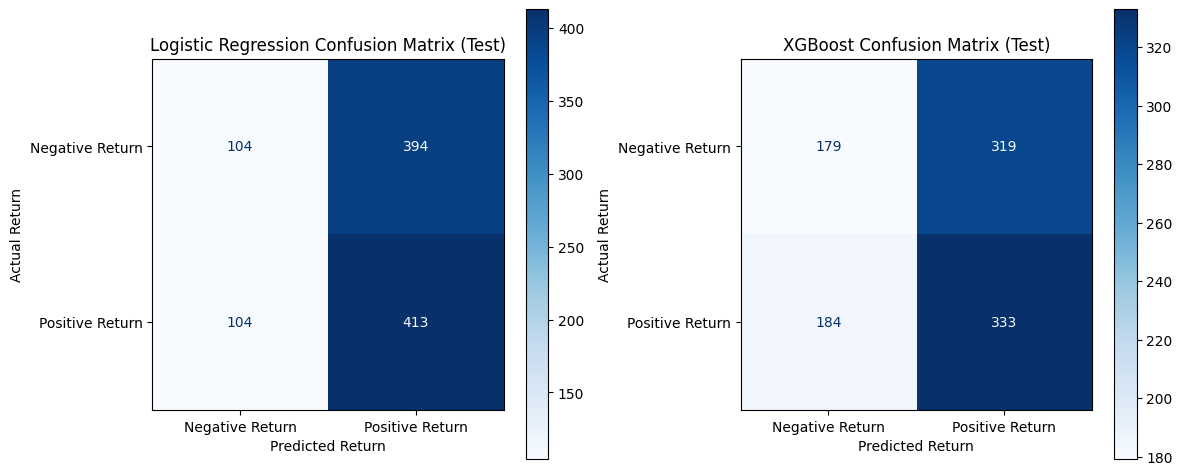

<Figure size 800x600 with 0 Axes>

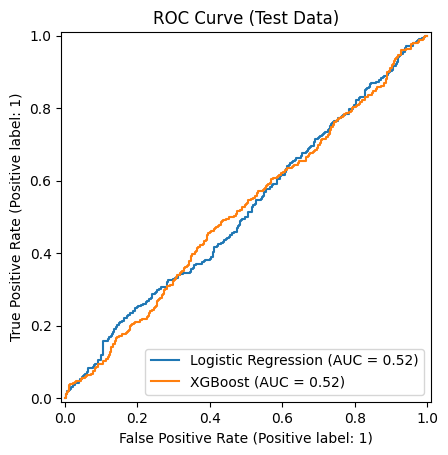

In [21]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# 1. Use the trained Logistic Regression model (lr_model) to make predictions on the X_test data.
y_test_lr_pred = lr_model.predict(X_test)

# 2. Use the trained XGBoost model (xgb_model) to make predictions on the X_test data.
y_test_xgb_pred = xgb_model.predict(X_test)

# 3. Calculate and print the accuracy score for the Logistic Regression model on the test data.
lr_test_accuracy = accuracy_score(y_test, y_test_lr_pred)
print(f"Logistic Regression Test Accuracy: {lr_test_accuracy:.4f}")

# 4. Calculate and print the accuracy score for the XGBoost model on the test data.
xgb_test_accuracy = accuracy_score(y_test, y_test_xgb_pred)
print(f"XGBoost Test Accuracy: {xgb_test_accuracy:.4f}")

# 5. Print a classification report for the Logistic Regression model on the test data.
print("\nLogistic Regression Test Classification Report:")
print(classification_report(y_test, y_test_lr_pred))

# 6. Print a classification report for the XGBoost model on the test data.
print("\nXGBoost Test Classification Report:")
print(classification_report(y_test, y_test_xgb_pred))

# 7. Generate and display the confusion matrix for both models on the test data using ConfusionMatrixDisplay.
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_test, y_test_lr_pred,
                                         display_labels=["Negative Return", "Positive Return"],
                                         cmap=plt.cm.Blues,
                                         ax=axes[0])
axes[0].set_title("Logistic Regression Confusion Matrix (Test)")
axes[0].set_xlabel("Predicted Return")
axes[0].set_ylabel("Actual Return")

ConfusionMatrixDisplay.from_predictions(y_test, y_test_xgb_pred,
                                         display_labels=["Negative Return", "Positive Return"],
                                         cmap=plt.cm.Blues,
                                         ax=axes[1])
axes[1].set_title("XGBoost Confusion Matrix (Test)")
axes[1].set_xlabel("Predicted Return")
axes[1].set_ylabel("Actual Return")

plt.tight_layout()
plt.show()

# 8. Generate and display the ROC curve for both models on the test data using RocCurveDisplay.from_predictions.
plt.figure(figsize=(8, 6))
lr_roc_display = RocCurveDisplay.from_predictions(y_test, lr_model.predict_proba(X_test)[:, 1], name="Logistic Regression")
xgb_roc_display = RocCurveDisplay.from_predictions(y_test, xgb_model.predict_proba(X_test)[:, 1], name="XGBoost", ax=lr_roc_display.ax_)

plt.title("ROC Curve (Test Data)")
plt.show()

**Visualization of Buy / Sell signals**:

This visualization helps to visually assess how the generated buy and sell signals align with the historical price movements. You can see where the strategy would have theoretically entered (bought) and exited (sold a portion) positions based on the model's predictions. This can be a useful way to get an initial qualitative understanding of the strategy's behavior before looking at quantitative performance metrics

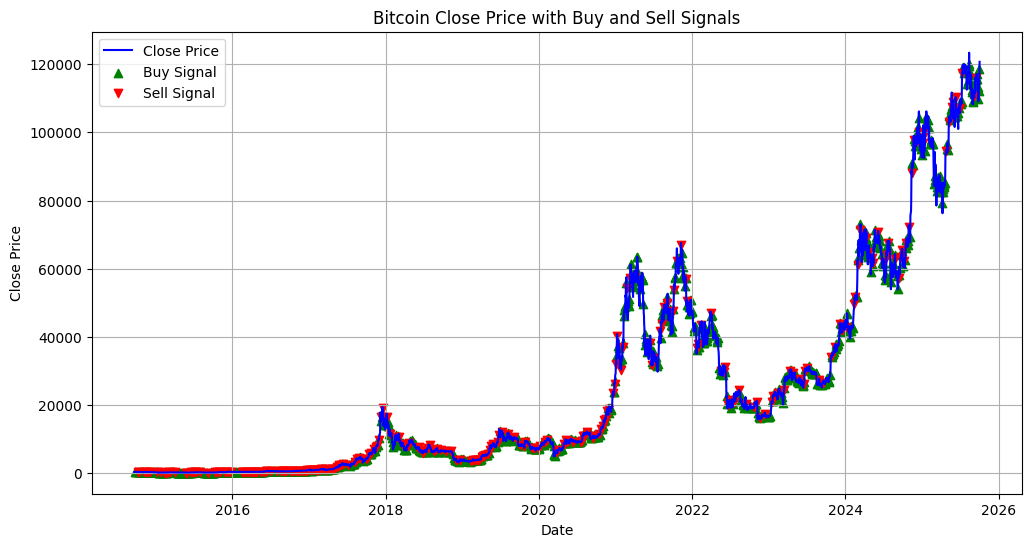

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure btc_pandas is available (convert from Polars if needed)
if isinstance(btc, pl.DataFrame):
    btc_pandas = btc.to_pandas()
elif 'btc_pandas' not in globals():
    print("btc_pandas DataFrame not found. Please run the data loading and processing cells.")
    # Exit or handle the error appropriately if the DataFrame is not available
else:
    pass # btc_pandas is already a pandas DataFrame

# Identify buy signals (Target changes from 0 to 1)
buy_signals = btc_pandas[(btc_pandas['Target'] == 1) & (btc_pandas['Target'].shift(1) == 0)]

# Identify sell signals (Target changes from 1 to 0 for three consecutive days)
# Check for Target=0 on the current day and Target=1 on the previous three days
sell_signals = btc_pandas[(btc_pandas['Target'] == 0) & (btc_pandas['Target'].shift(1) == 1) &
                          (btc_pandas['Target'].shift(2) == 1) & (btc_pandas['Target'].shift(3) == 1)]


# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(btc_pandas['Date'], btc_pandas['Close'], label='Close Price', color='blue')

# Plot buy signals as green triangles
plt.scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', alpha=1)

# Plot sell signals as red triangles pointing down
plt.scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Sell Signal', alpha=1)


# Add title and labels
plt.title('Bitcoin Close Price with Buy and Sell Signals')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

##Simple Buy Strategy :

The core of the buy strategy is driven by the Target variable, which is a binary prediction (1 for positive return, 0 for zero or negative return). A buy signal is generated when the Target changes from 0 on the previous day to 1 on the current day. This transition is interpreted as the model predicting an upward movement in the Bitcoin price after a period of non-positive movement.

The systematic investment plan aspect comes into play with the amount of capital used for each buy trade. Initially, the code used a fixed buy_amount of $250. However, based on a recent modification, the strategy now calculates the amount to spend on each buy as the maximum of two values:

The fixed buy_amount (which is set to 250).
5% of the current available capital.
This means that if 5% of the current capital is less than 250, the strategy will invest a minimum of 250. If 5% of the current capital is greater than 250, the strategy will invest 5% of the capital, allowing the investment amount to scale with the portfolio size.

When a buy signal is triggered and the amount to spend is determined, the strategy calculates how much Bitcoin can be bought with that capital using the previous day's closing price (CloseLag1). If the current available capital is greater than or equal to the calculated capital_to_spend, the trade is executed: the capital is reduced by capital_to_spend, and the corresponding amount of Bitcoin is added to the bitcoin_held.

In summary, the simple buy strategy is event-driven, buying only when a specific bullish signal from the predictive model is received, and it incorporates a systematic approach to determining the trade size, investing at least a fixed amount or a percentage of the growing capital, whichever is larger.

In [28]:
import pandas as pd
import numpy as np
import polars as pl # Import polars

# Ensure btc_pandas is available (convert from Polars if needed)
# If btc (Polars DataFrame) exists, convert it to pandas.
# Otherwise, try loading from the CSV.
if 'btc' in globals() and isinstance(btc, pl.DataFrame):
    btc_pandas = btc.to_pandas()
elif 'btc_pandas' not in globals():
    print("btc_pandas DataFrame not found. Trying to load from CSV.")
    try:
        btc_pandas = pd.read_csv("btc-with-computed-features.csv", parse_dates=['Date'])
    except Exception as e:
        print(f"Error loading btc-with-computed-features.csv for backtesting: {e}")
        print("Please ensure 'btc-with-computed-features.csv' exists or run the data processing steps.")
        # Exit or handle the error appropriately
        exit() # Or raise an exception
else:
    pass # btc_pandas is already a pandas DataFrame


def backtest_strategy(btc_data, y_pred, y_actual, initial_capital, buy_amount):
    """
    Backtests a simple trading strategy based on predicted Target variable.

    Args:
        btc_data (pd.DataFrame): DataFrame containing the historical data
                                   with 'Date', 'Close', and 'CloseLag1' columns.
                                   This is used for dates and prices.
        y_pred (np.ndarray): Predicted target values (0 or 1) from the model.
        y_actual (np.ndarray): Actual target values (0 or 1). Used for aligning
                               predictions with dates/prices if needed, though
                               primarily dates/prices from btc_data are used.
        initial_capital (float): The starting capital for the simulation.
        buy_amount (float): The amount of capital to use for each buy trade
                            (or a percentage of capital, as implemented).

    Returns:
        tuple: A tuple containing the final capital, remaining capital, and
               the amount of bitcoin held.
    """
    capital = initial_capital
    bitcoin_held = 0

    # Ensure y_pred and y_actual have the same length as the relevant btc_data subset
    # Assuming y_pred and y_actual correspond to the test_df data
    # We need to align the predictions with the test_df dates and prices

    # Find the starting index of the test data in the original btc_data
    # This assumes test_df was created by filtering btc based on date
    if 'test_df' not in globals() or not isinstance(test_df, pl.DataFrame):
         print("Error: 'test_df' Polars DataFrame not found. Please run the data splitting cell.")
         return capital, bitcoin_held, capital # Return initial capital if test_df is not available

    if test_df.is_empty():
        print("Test data is empty, cannot perform backtesting.")
        return capital, bitcoin_held, capital # Return initial capital if test_df is empty

    test_start_date = test_df['Date'].min()
    start_idx = btc_data[btc_data['Date'] == test_start_date].index[0]

    # Iterate through the test data period using indices relative to btc_data
    # The loop should iterate over the length of the test data predictions (y_pred)
    for i in range(1, len(y_pred)):
        # Get the index in the original btc_data (pandas) DataFrame
        current_btc_idx = start_idx + i
        # Get the index in the y_pred/y_actual arrays
        current_pred_idx = i
        previous_pred_idx = i - 1

        # Check if the predicted target changed from 0 to 1
        if y_pred[current_pred_idx] == 1 and y_pred[previous_pred_idx] == 0:
            # Calculate the number of Bitcoin futures to buy
            # Use the closing price of the previous day from the original data for a more realistic simulation
            # Ensure current_btc_idx is within bounds of btc_data
            if current_btc_idx < len(btc_data):
                buy_price = btc_data['CloseLag1'].iloc[current_btc_idx]
                if buy_price > 0: # Avoid division by zero
                    # Calculate the amount to spend: max of fixed buy_amount or 5% of current capital
                    capital_to_spend = max(buy_amount, capital * 0.05)
                    amount_to_buy = capital_to_spend / buy_price
                    # Execute the trade if enough capital is available
                    if capital >= capital_to_spend:
                        capital -= capital_to_spend
                        bitcoin_held += amount_to_buy
                        # print(f"Bought {amount_to_buy:.6f} BTC at {buy_price:.2f} on {btc_data['Date'].iloc[current_btc_idx].date()}") # Optional: uncomment for detailed logs
                    # else:
                        # print(f"Not enough capital to buy on {btc_data['Date'].iloc[current_btc_idx].date()}") # Optional: uncomment for detailed logs
            # else:
                # print(f"Index {current_btc_idx} out of bounds for btc_data during buy operation.")


    # Calculate the final capital
    # Use the last closing price from the original data to value the held Bitcoin futures
    last_price = btc_data['Close'].iloc[-1]
    final_capital = capital + (bitcoin_held * last_price)

    return capital, bitcoin_held, final_capital

# Call the function with the initial parameters and the test data predictions/actuals
initial_capital = 10000
buy_amount = 250 # Fixed buy amount if 5% of capital is less than this
# Assuming y_test_xgb_pred and y_test are available from previous cells
# Ensure test_df is available and is a Polars DataFrame before proceeding
if 'y_test_xgb_pred' in globals() and 'y_test' in globals() and 'test_df' in globals() and isinstance(test_df, pl.DataFrame):
    remaining_capital_simple_xgb, held_bitcoin_simple_xgb, final_portfolio_value_simple_xgb = backtest_strategy(btc_pandas, y_test_xgb_pred, y_test, initial_capital, buy_amount)

    print("--- Simple Strategy (XGBoost Predictions) ---")
    print(f"Initial Capital: ${initial_capital:.2f}")
    print(f"Uninvested Capital: ${remaining_capital_simple_xgb:.2f}")
    print(f"Final Capital: ${final_portfolio_value_simple_xgb:.2f}")
    print("-" * 35) # Separator line

    # Run the Simple Strategy backtest with Logistic Regression predictions
    if 'y_test_lr_pred' in globals():
        remaining_capital_simple_lr, held_bitcoin_simple_lr, final_portfolio_value_simple_lr = backtest_strategy(btc_pandas, y_test_lr_pred, y_test, initial_capital, buy_amount)

        print("--- Simple Strategy (Logistic Regression Predictions) ---")
        print(f"Initial Capital: ${initial_capital:.2f}")
        print(f"Uninvested Capital: ${remaining_capital_simple_lr:.2f}")
        print(f"Final Capital: ${final_portfolio_value_simple_lr:.2f}")
        print("-" * 35) # Separator line
    else:
         print("Logistic Regression test predictions (y_test_lr_pred) not found. Cannot run simple strategy with LR predictions.")


    # Compare with simple buy and hold over the test data period
    # Assuming the first available Close price in the test_df is the entry point
    if not test_df.is_empty():
        # Use Polars native methods to get the first and last elements
        initial_buy_price_for_comparison_test = test_df['Close'][0]
        simple_buy_hold_amount_test = initial_capital / initial_buy_price_for_comparison_test
        simple_buy_hold_final_capital_test = simple_buy_hold_amount_test * test_df['Close'][-1]

        print("--- Simple Buy and Hold (Test Period) ---")
        print(f"Initial Capital: ${initial_capital:.2f}")
        print(f"Final Capital: ${simple_buy_hold_final_capital_test:.2f}")
        print("-" * 35) # Separator line
    else:
        print("Test data is empty, cannot perform Buy and Hold comparison over the test period.")

else:
    print("Required variables (y_test_xgb_pred, y_test, test_df) not found or test_df is not a Polars DataFrame. Please run the model training and evaluation and data splitting cells.")

--- Simple Strategy (XGBoost Predictions) ---
Initial Capital: $10000.00
Uninvested Capital: $126.75
Final Capital: $43128.18
-----------------------------------
--- Simple Strategy (Logistic Regression Predictions) ---
Initial Capital: $10000.00
Uninvested Capital: $126.75
Final Capital: $12320.00
-----------------------------------
--- Simple Buy and Hold (Test Period) ---
Initial Capital: $10000.00
Final Capital: $66651.04
-----------------------------------


## Momentum-based systematic Buy and Sell strategy

This trading strategy operates based on signals from a predictive model. The sell rule is straightforward: if the model predicts a non-positive return for the three consecutive days (Target is 0), the strategy sells 5% of the current Bitcoin holdings. The buy rule is more focused on a shift in momentum: the strategy initiates a buy only when the model predicts a positive return for the next day (Target is 1) and this follows three consecutive days where the model predicted non-positive returns (Target was 0 for the three preceding days). When this specific buy signal occurs, the strategy allocates 10% of the current available capital to purchase Bitcoin. This approach aims to capture upward movements after a period of bearish or sideways price action while trimming holdings during predicted downturns.

In [30]:
import pandas as pd
import numpy as np
import polars as pl # Import polars

# Ensure btc_pandas is available (convert from Polars if needed)
# If btc (Polars DataFrame) exists, convert it to pandas.
# Otherwise, try loading from the CSV.
if 'btc' in globals() and isinstance(btc, pl.DataFrame):
    btc_pandas = btc.to_pandas()
elif 'btc_pandas' not in globals():
    print("btc_pandas DataFrame not found. Trying to load from CSV.")
    try:
        btc_pandas = pd.read_csv("btc-with-computed-features.csv", parse_dates=['Date'])
    except Exception as e:
        print(f"Error loading btc-with-computed-features.csv for backtesting: {e}")
        print("Please ensure 'btc-with-computed-features.csv' exists or run the data processing steps.")
        # Exit or handle the error appropriately
        exit() # Or raise an exception
else:
    pass # btc_pandas is already a pandas DataFrame


def backtest_momentum_strategy(btc_data, y_pred, y_actual, initial_capital):
    """
    Backtests a momentum-based trading strategy using predicted target values.

    Args:
        btc_data (pd.DataFrame): DataFrame containing the historical data
                                   with 'Date', 'Close', and 'CloseLag1' columns.
                                   This is used for dates and prices.
        y_pred (np.ndarray): Predicted target values (0 or 1) from the model.
        y_actual (np.ndarray): Actual target values (0 or 1). Used for aligning
                               predictions with dates/prices if needed, though
                               primarily dates/prices from btc_data are used.
        initial_capital (float): The starting capital for the simulation.

    Returns:
        tuple: A tuple containing the final capital, remaining capital, and
               the amount of bitcoin held.
    """
    capital = initial_capital
    bitcoin_held = 0

    # Ensure y_pred and y_actual have the same length as the relevant btc_data subset
    # Assuming y_pred and y_actual correspond to the test_df data
    # We need to align the predictions with the test_df dates and prices

    # Find the starting index of the test data in the original btc_data
    # This assumes test_df was created by filtering btc based on date
    # Ensure test_df is available and is a Polars DataFrame
    if 'test_df' not in globals() or not isinstance(test_df, pl.DataFrame):
         print("Error: 'test_df' Polars DataFrame not found. Please run the data splitting cell.")
         return capital, bitcoin_held, capital # Return initial capital if test_df is not available

    if test_df.is_empty():
        print("Test data is empty, cannot perform backtesting.")
        return capital, bitcoin_held, capital # Return initial capital if test_df is empty

    test_start_date = test_df['Date'].min()
    # Find the index in the pandas DataFrame btc_data
    start_idx = btc_data[btc_data['Date'] == test_start_date].index[0]

    # Iterate through the test data period using indices relative to btc_data
    # We start from the 3rd day of the test data period to check for 3 consecutive previous days
    # So the loop starts from index `start_idx + 3` in the btc_data DataFrame
    # and uses indices relative to y_pred/y_actual (which start from 0 for the test set)
    # The loop should iterate over the length of the test data predictions (y_pred)
    for i in range(3, len(y_pred)):
        # Get the index in the original btc_data (pandas) DataFrame
        current_btc_idx = start_idx + i
        # Get the index in the y_pred/y_actual arrays
        current_pred_idx = i
        previous_pred_idx_1 = i - 1
        previous_pred_idx_2 = i - 2
        previous_pred_idx_3 = i - 3

        # Ensure indices are within bounds of y_pred
        if previous_pred_idx_3 < 0 or current_pred_idx >= len(y_pred):
            continue # Skip if indices are out of bounds


        # Sell Condition: Sell 5% if predicted target is 0 for the current day and previous two days
        # This rule is slightly adjusted to use predicted values for the consecutive check
        if y_pred[current_pred_idx] == 0 and \
           y_pred[previous_pred_idx_1] == 0 and \
           y_pred[previous_pred_idx_2] == 0 and \
           bitcoin_held > 0:

            percentage_to_sell = 0.05
            amount_to_sell = bitcoin_held * percentage_to_sell

            # Use the closing price of the previous day from the original data for a more realistic simulation
            # Ensure current_btc_idx is within bounds of btc_data
            if current_btc_idx < len(btc_data):
                sell_price = btc_data['CloseLag1'].iloc[current_btc_idx]
                if sell_price > 0 and amount_to_sell > 0: # Avoid division by zero and selling zero
                    capital += amount_to_sell * sell_price
                    bitcoin_held -= amount_to_sell
                    # print(f"Sold {amount_to_sell:.6f} BTC at {sell_price:.2f} on {btc_data['Date'].iloc[current_btc_idx].date()}") # Optional: uncomment for detailed logs
            # else:
                # print(f"Index {current_btc_idx} out of bounds for btc_data during sell operation.")


        # Buy Condition: Buy 10% if the predicted momentum changes to buy after 3 consecutive days of sell (predicted Target was 0)
        # This rule uses predicted values for the consecutive check and the current buy signal
        elif y_pred[current_pred_idx] == 1 and \
             y_pred[previous_pred_idx_1] == 0 and \
             y_pred[previous_pred_idx_2] == 0 and \
             y_pred[previous_pred_idx_3] == 0:

            percentage_to_buy = 0.10
            capital_to_spend = capital * percentage_to_buy

            # Use the closing price of the previous day from the original data for a more realistic simulation
            # Ensure current_btc_idx is within bounds of btc_data
            if current_btc_idx < len(btc_data):
                buy_price = btc_data['CloseLag1'].iloc[current_btc_idx]
                if buy_price > 0 and capital_to_spend > 0: # Avoid division by zero and spending zero
                     amount_to_buy = capital_to_spend / buy_price
                     # Execute the trade if enough capital is available
                     if capital >= capital_to_spend:
                        capital -= capital_to_spend
                        bitcoin_held += amount_to_buy
                        # print(f"Bought {amount_to_buy:.6f} BTC at {buy_price:.2f} on {btc_data['Date'].iloc[current_btc_idx].date()}") # Optional: uncomment for detailed logs
                     # else:
                        # print(f"Not enough capital to buy on {btc_data['Date'].iloc[current_btc_idx].date()}") # Optional: uncomment for detailed logs
            # else:
                # print(f"Index {current_btc_idx} out of bounds for btc_data during buy operation.")


    # Calculate the final capital
    # Use the last closing price from the original data to value the held Bitcoin futures
    last_price = btc_data['Close'].iloc[-1]
    final_capital = capital + (bitcoin_held * last_price)

    return capital, bitcoin_held, final_capital

# Call the function with the initial parameters and the test data predictions/actuals
initial_capital = 10000
# Assuming y_test_xgb_pred and y_test are available from previous cells
# Ensure test_df is available and is a Polars DataFrame before proceeding
if 'y_test_xgb_pred' in globals() and 'y_test' in globals() and 'test_df' in globals() and isinstance(test_df, pl.DataFrame):
    remaining_capital_momentum_xgb, held_bitcoin_momentum_xgb, final_portfolio_value_momentum_xgb = backtest_momentum_strategy(btc_pandas, y_test_xgb_pred, y_test, initial_capital)

    print("--- Momentum Strategy (XGBoost Predictions) ---")
    print(f"Initial Capital: ${initial_capital:.2f}")
    print(f"Uninvested Capital: ${remaining_capital_momentum_xgb:.2f}")
    print(f"Final Capital: ${final_portfolio_value_momentum_xgb:.2f}")
    print("-" * 35) # Separator line

    # Run the Momentum Strategy backtest with Logistic Regression predictions
    if 'y_test_lr_pred' in globals():
        remaining_capital_momentum_lr, held_bitcoin_momentum_lr, final_portfolio_value_momentum_lr = backtest_momentum_strategy(btc_pandas, y_test_lr_pred, y_test, initial_capital)

        print("--- Momentum Strategy (Logistic Regression Predictions) ---")
        print(f"Initial Capital: ${initial_capital:.2f}")
        print(f"Uninvested Capital: ${remaining_capital_momentum_lr:.2f}")
        print(f"Final Capital: ${final_portfolio_value_momentum_lr:.2f}")
        print("-" * 35) # Separator line
    else:
         print("Logistic Regression test predictions (y_test_lr_pred) not found. Cannot run momentum strategy with LR predictions.")


    # Compare with simple buy and hold over the test data period
    # This part remains the same as it's a benchmark
    if not test_df.is_empty():
        # Use Polars native methods to get the first and last elements
        initial_buy_price_for_comparison_test = test_df['Close'][0]
        simple_buy_hold_amount_test = initial_capital / initial_buy_price_for_comparison_test
        simple_buy_hold_final_capital_test = simple_buy_hold_amount_test * test_df['Close'][-1]

        # The Simple Buy and Hold comparison is already included in the simple strategy section,
        # so we don't need to print it again here to avoid redundancy.
        pass

else:
    print("Required variables (y_test_xgb_pred, y_test, test_df) not found or test_df is not a Polars DataFrame. Please run the model training and evaluation and data splitting cells.")

--- Momentum Strategy (XGBoost Predictions) ---
Initial Capital: $10000.00
Uninvested Capital: $7451.02
Final Capital: $14629.15
-----------------------------------
--- Momentum Strategy (Logistic Regression Predictions) ---
Initial Capital: $10000.00
Uninvested Capital: $8738.62
Final Capital: $10787.96
-----------------------------------


## Summary:

### Data Analysis Key Findings

* The model evaluation on the hold-out test data (2025) shows that both the Logistic Regression and XGBoost models achieved an accuracy slightly above 50%.
* The Logistic Regression model on the test data resulted in an accuracy of 0.5094. The classification report indicates a precision of 0.51 for predicting positive returns and a recall of 0.80.
* The XGBoost model on the test data resulted in an accuracy of 0.5044. The classification report shows a precision of 0.51 for predicting positive returns and a recall of 0.64.
* The simple Buy and Hold strategy over the test data period (2025) yielded a final capital of \$66651.04 starting with \$10000.00.
* When using the **XGBoost** model's predictions on the test data:
    * The Simple Buy strategy resulted in a final portfolio value of \$43128.18 starting with \$10000.00.
    * The Momentum strategy resulted in a final portfolio value of \$14629.15 starting with \$10000.00.
* When using the **Logistic Regression** model's predictions on the test data:
    * The Simple Buy strategy resulted in a final portfolio value of \$12320.00 starting with \$10000.00.
    * The Momentum strategy resulted in a final portfolio value of \$10787.96 starting with \$10000.00.

### Insights or Next Steps

* The performance of both models on the test data suggests that predicting the daily direction of Bitcoin price movements with high accuracy using these features is challenging. An accuracy slightly above 50% indicates the models perform only slightly better than random chance on unseen data.
* Comparing the backtesting results, the Simple Buy and Hold strategy over the test period significantly outperformed both the Simple Buy and Momentum strategies that relied on the model predictions.
* Between the two models, the XGBoost model's predictions led to higher final portfolio values for both the Simple Buy and Momentum strategies compared to the Logistic Regression model's predictions, although neither outperformed the simple Buy and Hold benchmark during this specific test period (2025).
* Further research could explore:
    * Incorporating additional features (e.g., sentiment data, macroeconomic indicators, on-chain analytics).
    * Experimenting with different model architectures and hyperparameter tuning approaches.
    * Optimizing the trading strategy rules (e.g., different buy/sell percentages, different lookback periods for momentum).
    * Evaluating performance using other financial metrics (e.g., Sharpe ratio, maximum drawdown).
    * Investigating if the models show profitability in different market regimes (e.g., bear markets, sideways markets).

## Summary:

### Data Analysis Key Findings

* The AUC score improved from 0.86 to 0.87-0.89 after including RSI and Volume features. Further increase the estimators to 500 greatly improved the score to 0.91. There may a risk of overfitting the XGClassifier model to data
* The naive Buy and Hold strategy without using any prediction would work great (in hindsight) for Bitcoin since it has seen unprecedented upside since it launch. An initial investement of \$10K in 2014 would yeild \$3,025,950.44 in 2025.
* An simple but slightly enhanced version of the Buy and Hold, where you buy a fixed amount of bitcoin, \$250, each time on a generated buy signal would have yeild \$4,108,172.17 in today's amount. Both these strategies are idealistic, but not unrealistic in the past 11 years of tremendous growth in Bitcoin value.
* A simple buy and hold strategy over the same period yielded a significantly higher final capital of \$862,469.05.
* A more practical yet simple momentum-based strategy, where you would sell 10% of the holding after 3 consecutive days of dip in Bitcoin price, and buy 10% back when the momentum shifts to a buy (Trading Signal 1), would yeild \$1,732,348.87. This is a more realistic and practical approach to investing.

### Insights or Next Steps

* Buy and hold would work the best of Bitcoin over past 11 years. However, that strategy may not have been realistic due to huge market speculations and fluctuations in Bitcoin price.
* The trading strategies are profitable because Bitcoin prices have a huge upward graph. It may be worth building a mean reversal based strategy and see its performance against momentum-based strategies.

## References

* [yfinance GitHub](https://github.com/ranaroussi/yfinance)
* [yfinance Documentation](https://ranaroussi.github.io/yfinance/)
* [Polars Online User Guide](https://docs.pola.rs/)
* [Build Polars Database](https://www.pyquantnews.com/free-python-resources/build-stock-database-locally-with-polars)
* [YouTube. Polars and Time Series: What It Can Do, and How to Overcome Any Limitation](https://www.youtube.com/watch?v=qz-zAHBz6Ks)
* [Awesome Quant: Python for Quantiative Finance](https://wilsonfreitas.github.io/awesome-quant/)
* [Cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)
* [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)
* [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
* [Hyperparameter Tuning](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)
* [Metrics and Scoring](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)
* [Introduction to Boosted Trees](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
* [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/index.html)
* [XGBoost in Python documentation](https://xgboost-clone.readthedocs.io/en/latest/python/python_intro.html)
* [Auto-Sklearn for AutoML in an Scikit-Learn Environment](https://www.automl.org/automl-for-x/tabular-data/auto-sklearn/).